In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import time
import gc
import copy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

In [2]:
#file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
file_numbers = [1 ,2]
structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}


def preprocess(data):
    #data shape: (trials, time, neurons)
    trials, time, num_neurons = data.shape
    z = np.zeros_like(data)

    for neuron in range(num_neurons):
        for t in range(time):
            vals = data[:, t, neuron]  #this is all the data for given neuron at given time point
            std = np.std(vals)
            if std > 1e-6:
                z[:, t, neuron] = (vals - np.mean(vals)) / std    #zscore if there is a stdev
            else:
                z[:, t, neuron] = np.median(vals)   #returnt the median value otherwise  (median rather than mean in case of large variability in a singel point)

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


def get_data(file_number):
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))
  
    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]
    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0) & (label_left != label_right))[0]  #indices of agg where left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left != label_right))[0]  #indices of agg where right

    left_attleft = data['SP'][0][0][left_indices_agg]
    left_attright = data['SP'][0][0][right_indices_agg]

    right_attleft = data['SP'][0][1][left_indices_agg]
    right_attright = data['SP'][0][1][right_indices_agg]

    att_attleft = data['SP'][0][2][left_indices_agg]
    att_attright = data['SP'][0][2][right_indices_agg]


    num_trials_left, num_samples, num_neurons = left_attleft.shape
    num_trials_right = left_attright.shape[0]
    num_neurons_attention = 80

    return left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, num_trials_left, num_trials_right, num_samples, num_neurons, num_neurons_attention


data_left_attleft = []
data_left_attright = []
data_right_attleft = []
data_right_attright = []
data_att_attleft = []
data_att_attright = []

def collect_data():
    for file_number in file_numbers:
        left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, num_trials_left, num_trials_right, num_samples, num_neurons, num_neurons_attention = get_data(file_number)
        data_left_attleft.append(left_attleft)
        data_left_attright.append(left_attright)
        data_right_attleft.append(right_attleft)   
        data_right_attright.append(right_attright)
        data_att_attleft.append(att_attleft)
        data_att_attright.append(att_attright)

    return data_left_attleft, data_left_attright, data_right_attleft, data_right_attright, data_att_attleft, data_att_attright

   


In [3]:
data_left_attleft, data_left_attright, data_right_attleft, data_right_attright, data_att_attleft, data_att_attright = collect_data()

In [4]:
def firing_rates(data, file_idx=0):
    plot_data = data[file_idx] 
    trials, time, neurons = plot_data.shape
    
    #find mean firing rate per neuron across trials and time
    firing_rates = plot_data.mean(axis=(0, 1))  # shape: (neurons,)
    
    
    return firing_rates

firing_rates = firing_rates(data_att_attleft, file_idx=0)


In [11]:
from sklearn.neural_network import MLPClassifier


def prep_data_by_trial(data_in, data_out, firing_threshold=0.01, t_start=100, t_end=350):
    data_in = data_in[:, t_start:t_end, :]
    data_out = data_out[:, t_start:t_end, :]

    n_trials, _, input_neurons = data_in.shape
    _, _, output_neurons = data_out.shape

    n_train = int(0.8 * n_trials)
    X_train_raw, X_test_raw = data_in[:n_train], data_in[n_train:]
    Y_train_raw, Y_test_raw = data_out[:n_train], data_out[n_train:]

    X_train = X_train_raw.reshape(-1, input_neurons)
    X_test = X_test_raw.reshape(-1, input_neurons)
    Y_train = Y_train_raw.reshape(-1, output_neurons)
    Y_test = Y_test_raw.reshape(-1, output_neurons)

    mean_rates = Y_train.mean(axis=0)
    most_active = np.where(mean_rates > firing_threshold)[0]
    least_active = np.where(mean_rates <= firing_threshold)[0]

    return X_train, X_test, Y_train, Y_test, most_active, least_active


def train_MLP(X, y, C = 1.0):
    model = MLPClassifier(
        hidden_layer_sizes=(100,),    # One hidden layer with 100 neurons
        activation='relu',            # Non-linearity
        solver='adam',                # Good default for neural nets
        max_iter=50,                 # You can increase this if it's not converging
        verbose=True                  # So you can see training progress
    )
    model.fit(X, y)
    return model
#will run this on the training data

input_data = data_left_attleft[0]
output_data = data_att_attleft[0]

X_train, X_test, Y_train, Y_test, most_active, _ = prep_data_by_trial(input_data, output_data)

target_neuron = most_active[0]
y_train = Y_train[:, target_neuron]
y_test = Y_test[:, target_neuron]

model = train_MLP(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f'Accuracy on test set for neuron {target_neuron}: {accuracy:.2f}')

spike_rate = np.mean(y_test)
print(f"Spike rate in test set: {spike_rate:.3f}")

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print(y_pred.shape)




Iteration 1, loss = 0.37200725
Iteration 2, loss = 0.30004517
Iteration 3, loss = 0.29814362
Iteration 4, loss = 0.29685813
Iteration 5, loss = 0.29553435
Iteration 6, loss = 0.29413677
Iteration 7, loss = 0.29268147
Iteration 8, loss = 0.29086418
Iteration 9, loss = 0.28954482
Iteration 10, loss = 0.28801457
Iteration 11, loss = 0.28644185
Iteration 12, loss = 0.28480231
Iteration 13, loss = 0.28326043
Iteration 14, loss = 0.28196585
Iteration 15, loss = 0.28053619
Iteration 16, loss = 0.27909060
Iteration 17, loss = 0.27782065
Iteration 18, loss = 0.27656209
Iteration 19, loss = 0.27564864
Iteration 20, loss = 0.27459103
Iteration 21, loss = 0.27328165
Iteration 22, loss = 0.27209469
Iteration 23, loss = 0.27121736
Iteration 24, loss = 0.27026663
Iteration 25, loss = 0.26926845
Iteration 26, loss = 0.26819934
Iteration 27, loss = 0.26751142
Iteration 28, loss = 0.26679046
Iteration 29, loss = 0.26597401
Iteration 30, loss = 0.26513419
Iteration 31, loss = 0.26431462
Iteration 32, los

c:\Users\joshu\nice\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


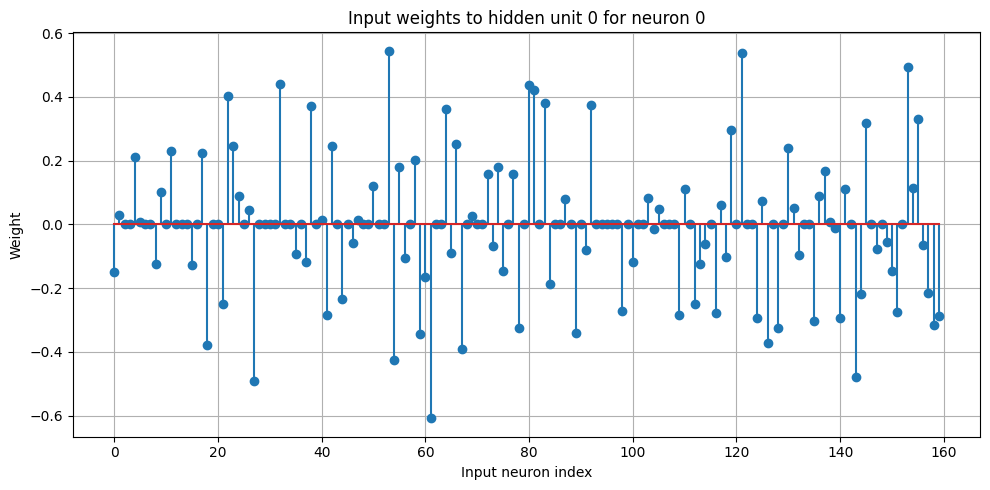

In [10]:
# First layer weights
weights = model.coefs_[0][:, 0]  # weights from inputs to first hidden unit (example)
nonzero = np.where(weights != 0)[0]

plt.figure(figsize=(10, 5))
plt.stem(nonzero, weights[nonzero])
plt.xlabel("Input neuron index")
plt.ylabel("Weight")
plt.title(f"Input weights to hidden unit 0 for neuron {target_neuron}")
plt.grid(True)
plt.tight_layout()
plt.show()